# Tutorial 3
### Problems and solvers

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
from dedalus.extras.plot_tools import plot_bot_2d
figkw = {'figsize':(6,4), 'dpi':100}

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# Bases
xcoord = d3.Coordinate('x')
dist = d3.Distributor(xcoord, dtype=np.complex128)
xbasis = d3.Chebyshev(xcoord, 1024, bounds=(0, 300), dealias=2)

# Fields
u = dist.Field(name='u', bases=xbasis)
tau1 = dist.Field(name='tau1')
tau2 = dist.Field(name='tau2')

# Problem
problem = d3.IVP([u, tau1, tau2], namespace=locals())

In [4]:
#ncc = dist.Field(bases=zbasis)
#ncc['g'] = z**2

In [5]:
# Substitutions
dx = lambda A: d3.Differentiate(A, xcoord)
magsq_u = u * np.conj(u)
b = 0.5
c = -1.76

# Tau polynomials
tau_basis = xbasis.derivative_basis(2)
p1 = dist.Field(bases=tau_basis)
p2 = dist.Field(bases=tau_basis)
p1['c'][-1] = 1
p2['c'][-2] = 2

In [6]:
# Add main equation, with linear terms on the LHS and nonlinear terms on the RHS
problem.add_equation("dt(u) - u - (1 + 1j*b)*dx(dx(u)) + tau1*p1 + tau2*p2 = - (1 + 1j*c) * magsq_u * u")

# Add boundary conditions
problem.add_equation("u(x='left') = 0")
problem.add_equation("u(x='right') = 0")

{'eqn': interp(<Field 139837752978000>, x=right),
 'LHS': interp(<Field 139837752978000>, x=right),
 'RHS': 0,
 'condition': 'True',
 'tensorsig': (),
 'dtype': numpy.complex128,
 'valid_modes': array([ True]),
 'M': 0,
 'L': interp(<Field 139837752978000>, x=right),
 'F': <Field 139837753348432>,
 'domain': <dedalus.core.domain.Domain at 0x7f2e83a042d0>,
 'matrix_dependence': array([ True]),
 'matrix_coupling': array([ True])}

In [7]:
# Build solver
solver = problem.build_solver(d3.RK222)

2025-05-27 10:42:01,419 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 9.7e+00/s


In [8]:
# Stopping criteria
solver.stop_sim_time = 500

In [9]:
# Setup a sine wave
x = dist.local_grid(xbasis)
u['g'] = 1e-3 * np.sin(5 * np.pi * x / 300)

In [10]:
# Setup storage
u.change_scales(1)
u_list = [np.copy(u['g'])]
t_list = [solver.sim_time]

# Main loop
timestep = 0.05
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 10 == 0:
        u.change_scales(1)
        u_list.append(np.copy(u['g']))
        t_list.append(solver.sim_time)
    if solver.iteration % 1000 == 0:
        print('Completed iteration {}'.format(solver.iteration))

# Convert storage lists to arrays
u_array = np.array(u_list)
t_array = np.array(t_list)

Completed iteration 1000
Completed iteration 2000
Completed iteration 3000
Completed iteration 4000
Completed iteration 5000
Completed iteration 6000
Completed iteration 7000
Completed iteration 8000
Completed iteration 9000
Completed iteration 10000
2025-05-27 10:42:17,351 solvers 0/1 INFO :: Simulation stop time reached.


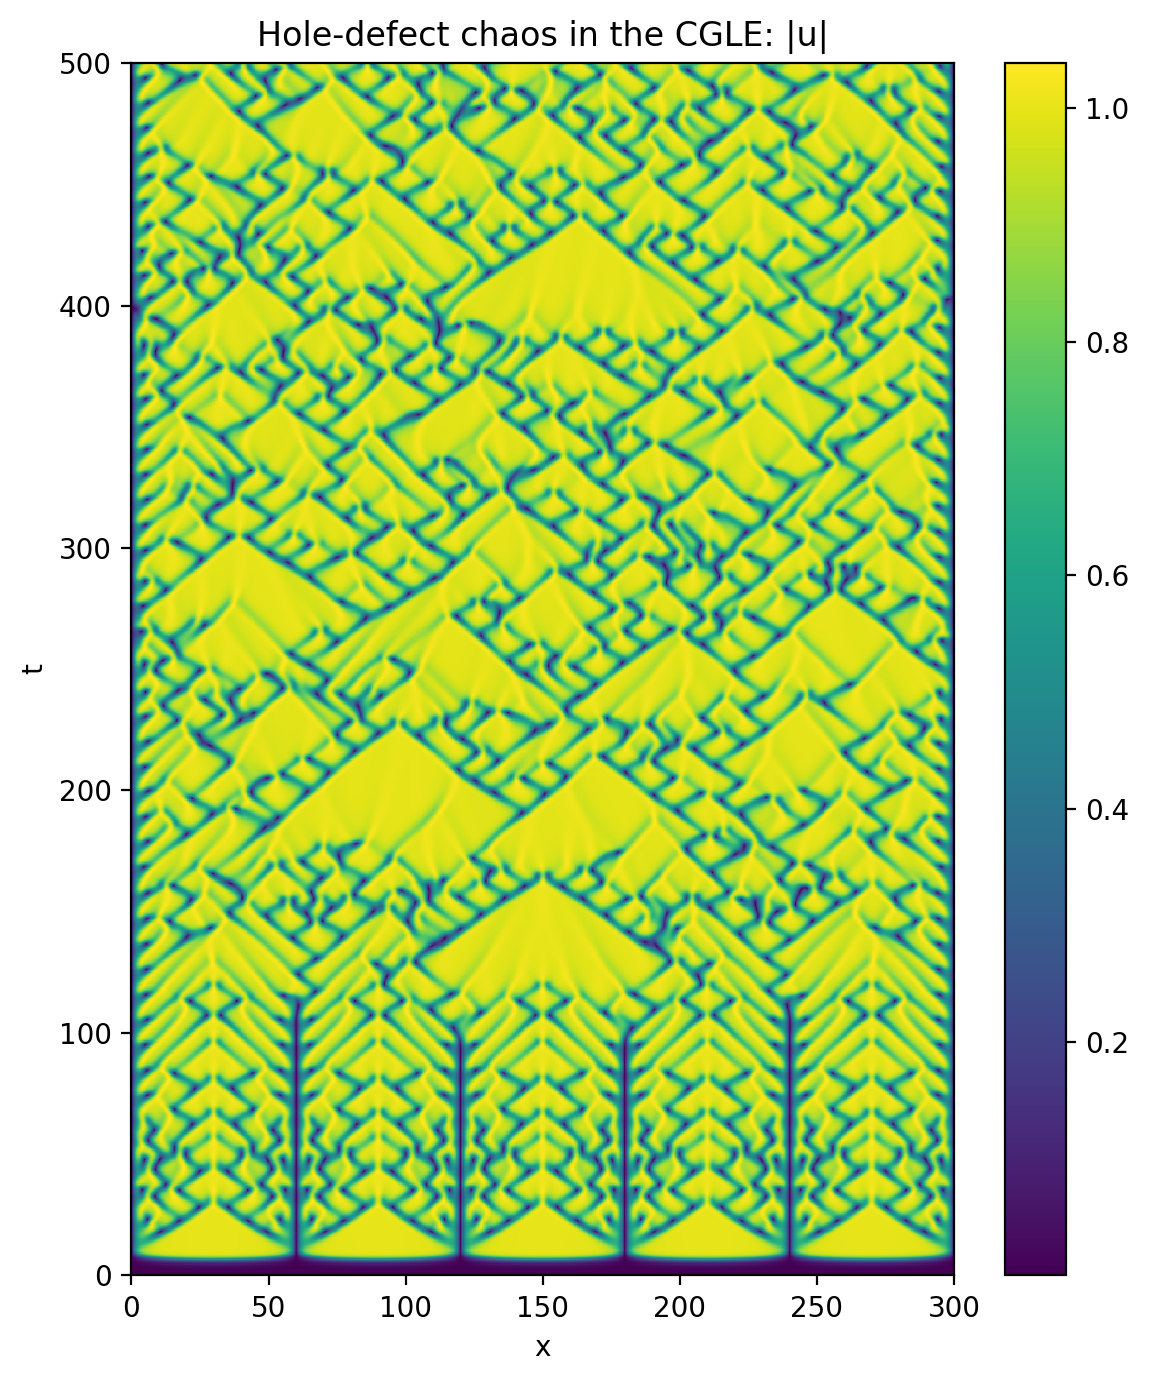

In [11]:
# Plot solution
plt.figure(figsize=(6, 7), dpi=100)
plt.pcolormesh(x, t_array, np.abs(u_array), shading='nearest')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Hole-defect chaos in the CGLE: |u|')
plt.tight_layout()